# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [23]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Helper Functions

In [17]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    """
    h, w = img.shape[0:2]
    slopes = []
    bvalues = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = float(y2-y1)/float(x2-x1)
            bvalues.append(y1-slope*x1)
            slopes.append(slope)
            
    abs_thresh = 0.35
            
    slopes = np.array(slopes)
    slope1 = np.median(slopes[slopes>abs_thresh])
    slope2 = np.median(slopes[slopes<-abs_thresh])
    
    thresh = 0.05
    
    slopes1 = []
    bvals1 = []
    slopes2 = []
    bvals2 = []
    
    for slope, b, line in zip(slopes, bvalues, lines):
        if (np.abs(slope-slope1) > thresh and np.abs(slope-slope2) > thresh) or np.abs(slope) < abs_thresh:
            continue
        if slope < 0:
            slopes1.append(slope)
            bvals1.append(b)
            
        if slope > 0:
            slopes2.append(slope)
            bvals2.append(b)
            
    final_slope1 = np.median(np.array(slopes1))
    final_slope2 = np.median(np.array(slopes2))
    final_bvals1 = np.median(np.array(bvals1))
    final_bvals2 = np.median(np.array(bvals2))
    for slope, b in zip([final_slope1, final_slope2], [final_bvals1, final_bvals2]):
        if slope != slope:
            continue
        Y1 = h
        X1 = int((Y1-b)/slope)
        Y2 = 325
        X2 = int((Y2-b)/slope)
        cv2.line(img, (X1, Y1), (X2, Y2), [255, 128+int(slope*100), 0], thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=10)
    return lines, line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

# The pipeline

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class ImageProcessor(object):
    def __init__(self):
        self.line_params = None
    
    def extract_lane_lines_image(self, input_image, low_thresh=100, high_thresh=200, kernel_size=9, 
                         lower_left_x = 111, lower_right_x = 920, vertical_center=325,
                         upper_left_x = 440, upper_right_x = 520,
                         hough_thresh = 11,
                        hough_min = 8,
                          hough_gap = 6):
        ih, iw = input_image.shape[0:2]
        h = 540
        w = 960
        image = cv2.resize(input_image, (w,h))
        pts = np.array([[[lower_left_x, h],
                       [upper_left_x, vertical_center],
                       [upper_right_x, vertical_center],
                       [lower_right_x, h]]], dtype=np.int32)
        canny_image = canny(gaussian_blur(image, kernel_size), low_thresh, high_thresh)
        canny_image = region_of_interest(canny_image, pts)
        lines, canny_image = self.hough_lines(canny_image, 1, 0.01, hough_thresh, hough_min, hough_gap)
        #canny_image = cv2.dilate(canny_image, np.ones((9,9)))
        #canny_image = cv2.erode(canny_image, np.ones((11,11)))

        return cv2.resize(canny_image, (iw, ih)), lines
    
    def hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap):
        """
        `img` should be the output of a Canny transform.

        Returns an image with hough lines drawn.
        """
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        self.draw_lines(line_img, lines, thickness=10)
        return lines, line_img
    
    def draw_lines(self, img, lines, color=[255, 0, 0], thickness=2):
        """
        """
        h, w = img.shape[0:2]
        slopes = []
        bvalues = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = float(y2-y1)/float(x2-x1)
                bvalues.append(y1-slope*x1)
                slopes.append(slope)

        abs_thresh = 0.35

        slopes = np.array(slopes)
        slope1 = np.median(slopes[slopes>abs_thresh])
        slope2 = np.median(slopes[slopes<-abs_thresh])

        thresh = 0.05

        slopes1 = []
        bvals1 = []
        slopes2 = []
        bvals2 = []

        for slope, b, line in zip(slopes, bvalues, lines):
            if (np.abs(slope-slope1) > thresh and np.abs(slope-slope2) > thresh) or np.abs(slope) < abs_thresh:
                continue
            if slope < 0:
                slopes1.append(slope)
                bvals1.append(b)

            if slope > 0:
                slopes2.append(slope)
                bvals2.append(b)

        final_slope1 = np.median(np.array(slopes1))
        final_slope2 = np.median(np.array(slopes2))
        final_bvals1 = np.median(np.array(bvals1))
        final_bvals2 = np.median(np.array(bvals2))
        
        line_params = np.array([final_slope1,final_slope2, final_bvals1, final_bvals2])
        
        if self.line_params == None:
            self.line_params = line_params
        else:
            for i in range(len(self.line_params)):
                if not np.isnan(line_params[i]):
                    self.line_params[i] = self.line_params[i]*0.8 + line_params[i]*0.2

            
        final_slope1, final_slope2, final_bvals1, final_bvals2 = self.line_params
        
        for slope, b in zip([final_slope1, final_slope2], [final_bvals1, final_bvals2]):
            if slope != slope:
                continue
            Y1 = h
            X1 = int((Y1-b)/slope)
            Y2 = 325
            X2 = int((Y2-b)/slope)
            cv2.line(img, (X1, Y1), (X2, Y2), [255, 128+int(slope*100), 0], thickness)
    
    def process_image(self, image):
        # NOTE: The output you return should be a color image (3 channel) for processing video below
        # TODO: put your pipeline here,
        # you should return the final output (image where lines are drawn on lanes)
        canny_image, lines = self.extract_lane_lines_image(image)
        #canny_image = np.dstack((canny_image, np.zeros_like(canny_image), np.zeros_like(canny_image)))
        canny_image = weighted_img(canny_image, image, α=0.5)
        return canny_image

## Test on Videos

In [19]:
ip = ImageProcessor()
white_output = 'test_videos_output/solidWhiteRight.mp4'
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(ip.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 28.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.66 s, sys: 728 ms, total: 6.39 s
Wall time: 8.69 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Solid Yellow Video

In [20]:
ip = ImageProcessor()
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(ip.process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:22<00:00, 32.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 17.8 s, sys: 648 ms, total: 18.4 s
Wall time: 23.1 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

In [21]:
ip = ImageProcessor()
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(ip.process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:25<00:00,  9.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 41.7 s, sys: 448 ms, total: 42.2 s
Wall time: 28.1 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# Code I used to tinker with params

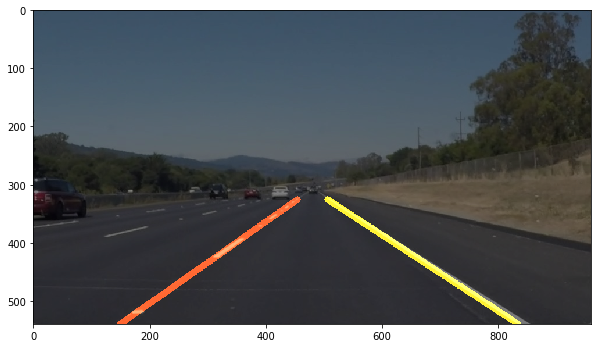

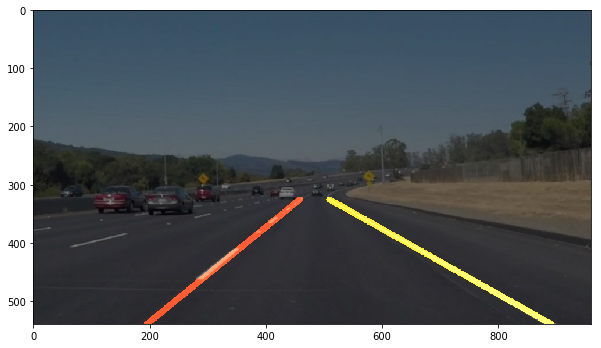

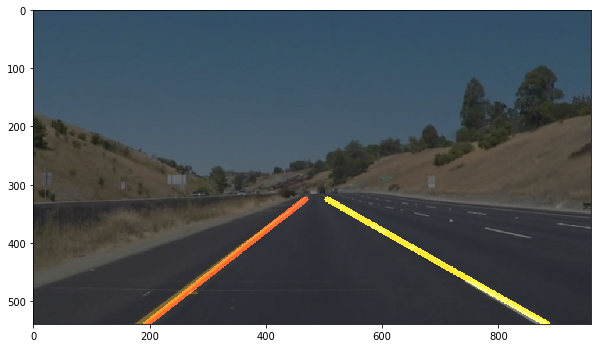

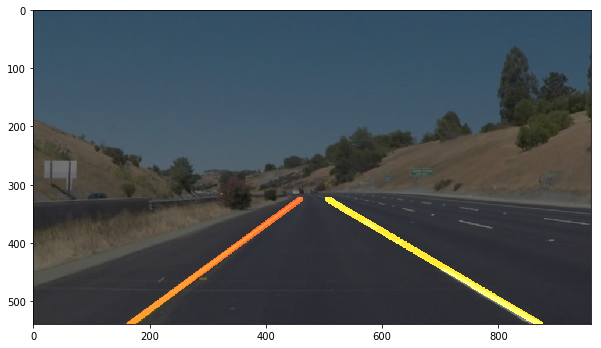

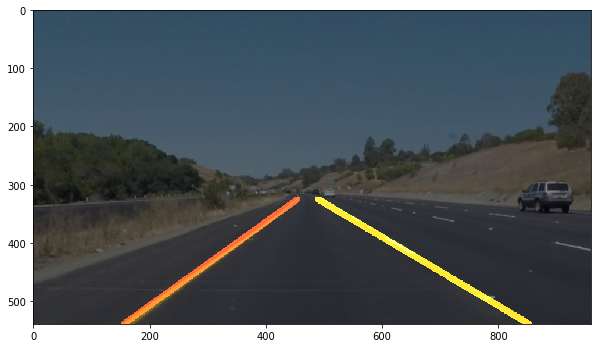

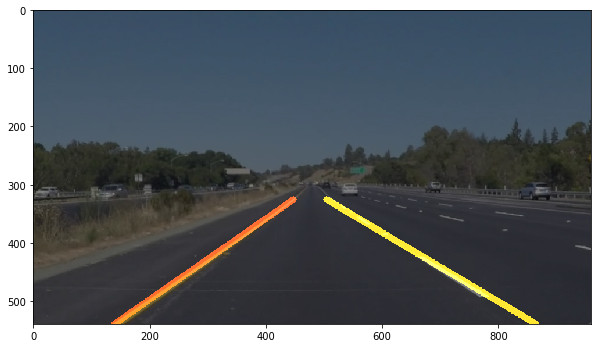

In [5]:
from ipywidgets import interactive
from IPython.display import display

dirname = "test_images/"

images = [mpimg.imread(dirname+fname) for fname in os.listdir(dirname)]
h, w = images[0].shape[0:2]

def extract_lane_lines_image(input_image, low_thresh=100, high_thresh=200, kernel_size=9, 
                         lower_left_x = 111, lower_right_x = 920, vertical_center=325,
                         upper_left_x = 440, upper_right_x = 520,
                         hough_thresh = 11,
                        hough_min = 8,
                          hough_gap = 6):
    ih, iw = input_image.shape[0:2]
    h = 540
    w = 960
    image = cv2.resize(input_image, (w,h))
    pts = np.array([[[lower_left_x, h],
                   [upper_left_x, vertical_center],
                   [upper_right_x, vertical_center],
                   [lower_right_x, h]]], dtype=np.int32)
    canny_image = canny(gaussian_blur(image, kernel_size), low_thresh, high_thresh)
    canny_image = region_of_interest(canny_image, pts)
    lines, canny_image = hough_lines(canny_image, 1, 0.01, hough_thresh, hough_min, hough_gap)
    #canny_image = cv2.dilate(canny_image, np.ones((9,9)))
    #canny_image = cv2.erode(canny_image, np.ones((11,11)))
    
    return cv2.resize(canny_image, (iw, ih)), lines


def gaussian_canny_widget(low_thresh=100, high_thresh=200, kernel_size=9, 
                         lower_left_x = 111, lower_right_x = 920, vertical_center=325,
                         upper_left_x = 446, upper_right_x = 516,
                         hough_thresh = 33,
                        hough_min = 8,
                          hough_gap = 18
                         ):
    for image in images:
        plt.figure(figsize=(10,10))
        canny_image, _ = extract_lane_lines_image(image, hough_thresh=hough_thresh,
                        hough_min=hough_min,
                          hough_gap=hough_gap)
        #canny_image = np.dstack((canny_image, np.zeros_like(canny_image), np.zeros_like(canny_image)))
        canny_image = weighted_img(canny_image, image, α=0.5)
        
        
        plt.imshow(canny_image, cmap='gray')

v = interactive(gaussian_canny_widget, 
                low_thresh=(0, 255), 
                high_thresh=(0, 255), 
                kernel_size=(1, 101, 2),
                vertical_center=(0, h),
                lower_left_x=(0, w),
                lower_right_x=(0,w),
                upper_right_x=(0,w),
                upper_left_x=(0,w),
                hough_thresh=(0, 255),
                hough_min=(0, 300),
                hough_gap=(0, 100)
               )
display(v)